# Paint Overview

_color, stroke, font, effects_

In [1]:
import skia
import contextlib
from IPython.display import display, Image

@contextlib.contextmanager
def draw_target(width=256, height=256):
    surface = skia.Surface(width, height)
    canvas = surface.getCanvas()
    yield canvas
    image = surface.makeImageSnapshot()
    display(Image(data=image.encodeToData()))

Anytime you draw something in Skia, and want to specify what color it is, or how it blends with the background, or what style or font to draw it in, you specify those attributes in a paint.

Unlike [Canvas](https://kyamagu.github.io/skia-python/_generate/skia.Canvas.html), paints do not maintain an internal stack of state (i.e. there is no save/restore on a paint). However, paints are relatively light-weight, so the client may create and maintain any number of paint objects, each set up for a particular use. Factoring all of these color and stylistic attributes out of the canvas state, and into (multiple) paint objects, allows canvas' save/restore to be that much more efficient, as all they have to do is maintain the stack of matrix and clip settings.

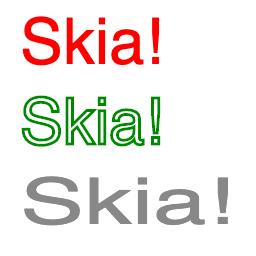

In [2]:
with draw_target() as canvas:
    paint1, paint2, paint3 = skia.Paint(), skia.Paint(), skia.Paint()

    paint1.setAntiAlias(True)
    paint1.setColor(skia.ColorSetRGB(255, 0, 0))
    paint1.setStyle(skia.Paint.kFill_Style)

    paint2.setAntiAlias(True)
    paint2.setColor(skia.ColorSetRGB(0, 136, 0))
    paint2.setStyle(skia.Paint.kStroke_Style)
    paint2.setStrokeWidth(3)

    paint3.setAntiAlias(True)
    paint3.setColor(skia.ColorSetRGB(136, 136, 136))

    blob1 = skia.TextBlob.MakeFromString(
        "Skia!", skia.Font(None, 64.0, 1.0, 0.0))
    blob2 = skia.TextBlob.MakeFromString(
        "Skia!", skia.Font(None, 64.0, 1.5, 0.0))
    
    canvas.clear(skia.ColorWHITE)
    canvas.drawTextBlob(blob1, 20.0, 64.0, paint1)
    canvas.drawTextBlob(blob1, 20.0, 144.0, paint2)
    canvas.drawTextBlob(blob2, 20.0, 224.0, paint3)

This shows three different paints, each set up to draw in a different style. Now the caller can intermix these paints freely, either using them as is, or modifying them as the drawing proceeds.

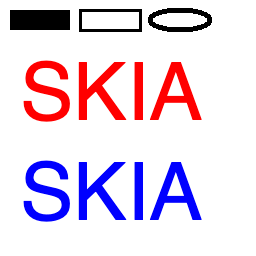

In [3]:
with draw_target() as canvas:
    fillPaint = skia.Paint()
    strokePaint = skia.Paint()
    strokePaint.setStyle(skia.Paint.kStroke_Style)
    strokePaint.setStrokeWidth(3.0)

    canvas.drawRect(skia.Rect.MakeXYWH(10, 10, 60, 20), fillPaint)
    canvas.drawRect(skia.Rect.MakeXYWH(80, 10, 60, 20), strokePaint)

    strokePaint.setStrokeWidth(5.0);
    canvas.drawOval(skia.Rect.MakeXYWH(150, 10, 60, 20), strokePaint)

    blob = skia.TextBlob.MakeFromString("SKIA", skia.Font(None, 80))

    fillPaint.setColor(skia.ColorSetARGB(0xFF, 0xFF, 0x00, 0x00))
    canvas.drawTextBlob(blob, 20, 120, fillPaint)

    fillPaint.setColor(skia.ColorSetARGB(0xFF, 0x00, 0x00, 0xFF))
    canvas.drawTextBlob(blob, 20, 220, fillPaint)

Beyond simple attributes such as color, strokes, and text values, paints support effects. These are subclasses of different aspects of the drawing pipeline, that when referenced by a paint (each of them is reference-counted), are called to override some part of the drawing pipeline.

For example, to draw using a gradient instead of a single color, assign a SkShader to the paint.

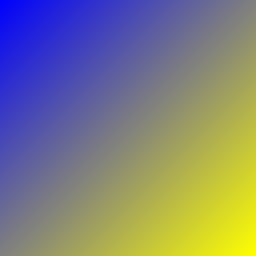

In [4]:
with draw_target() as canvas:
    points = [(0.0, 0.0), (256.0, 256.0)]
    colors = [0xFF0000FF, 0xFFFFFF00]  # Blue, Yellow in #RGBA
    paint = skia.Paint()
    paint.setShader(skia.GradientShader.MakeLinear(points, colors))
    canvas.drawPaint(paint)

Now, anything drawn with that paint will be drawn with the gradient specified in the call to `MakeLinear()`. The shader object that is returned is reference-counted. Whenever any effects object, like a shader, is assigned to a paint, its reference-count is increased by the paint. To balance this, the caller in the above example calls `unref()` on the shader once it has assigned it to the paint. Now the paint is the only "owner" of that shader, and it will automatically call `unref()` on the shader when either the paint goes out of scope, or if another shader (or null) is assigned to it.

There are 6 types of effects that can be assigned to a paint:

- `PathEffect` - modifications to the geometry (path) before it generates an alpha mask (e.g. dashing)
- `Rasterizer` - composing custom mask layers (e.g. shadows)
- `MaskFilter` - modifications to the alpha mask before it is colorized and drawn (e.g. blur)
- `Shader` - e.g. gradients (linear, radial, sweep), bitmap patterns (clamp, repeat, mirror)
- `ColorFilter` - modify the source color(s) before applying the xfermode (e.g. color matrix)
- `Xfermode` - e.g. porter-duff transfermodes, blend modes

Paints also hold a reference to a [Typeface](https://kyamagu.github.io/skia-python/_generate/skia.Typeface.html). The typeface represents a specific font style, to be used for measuring and drawing text. Speaking of which, paints are used not only for drawing text, but also for measuring it.

```
paint.measureText(...)
paint.getTextBounds(...)
paint.textToGlyphs(...)
paint.getFontMetrics(...)
```

## Xfermode
The following example demonstrates all of the Skia's standard transfer modes. In this example the source is a solid magenta color with a horizontal alpha gradient and the destination is a solid cyan color with a vertical alpha gradient.

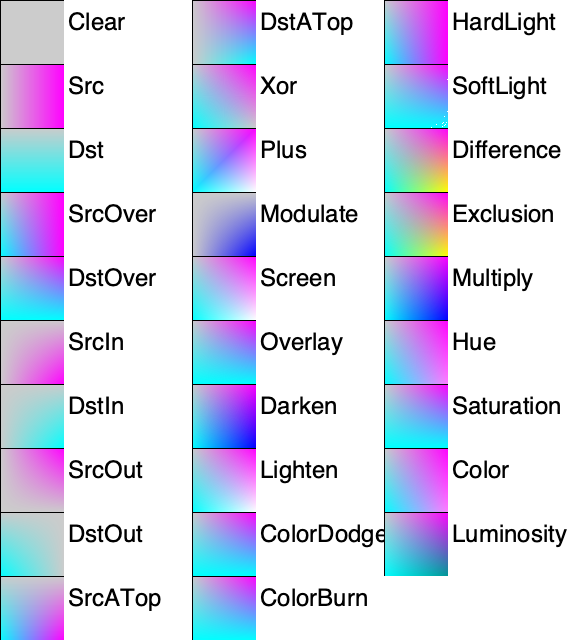

In [5]:
def draw_utf8_string(canvas, text, x, y, font, paint):
    canvas.drawTextBlob(
        skia.TextBlob.MakeFromString(text, font), x, y, paint)


with draw_target(576, 640) as canvas:
    modes = [
        skia.BlendMode.kClear,
        skia.BlendMode.kSrc,
        skia.BlendMode.kDst,
        skia.BlendMode.kSrcOver,
        skia.BlendMode.kDstOver,
        skia.BlendMode.kSrcIn,
        skia.BlendMode.kDstIn,
        skia.BlendMode.kSrcOut,
        skia.BlendMode.kDstOut,
        skia.BlendMode.kSrcATop,
        skia.BlendMode.kDstATop,
        skia.BlendMode.kXor,
        skia.BlendMode.kPlus,
        skia.BlendMode.kModulate,
        skia.BlendMode.kScreen,
        skia.BlendMode.kOverlay,
        skia.BlendMode.kDarken,
        skia.BlendMode.kLighten,
        skia.BlendMode.kColorDodge,
        skia.BlendMode.kColorBurn,
        skia.BlendMode.kHardLight,
        skia.BlendMode.kSoftLight,
        skia.BlendMode.kDifference,
        skia.BlendMode.kExclusion,
        skia.BlendMode.kMultiply,
        skia.BlendMode.kHue,
        skia.BlendMode.kSaturation,
        skia.BlendMode.kColor,
        skia.BlendMode.kLuminosity,
    ]
    rect = skia.Rect.MakeWH(64.0, 64.0)
    stroke, src, dst = skia.Paint(), skia.Paint(), skia.Paint()
    stroke.setStyle(skia.Paint.kStroke_Style)
    font = skia.Font(None, 24)
    srcPoints = [(0.0, 0.0), (64.0, 0.0)]
    srcColors = [skia.ColorMAGENTA & 0x00FFFFFF, skia.ColorMAGENTA]
    src.setShader(skia.GradientShader.MakeLinear(srcPoints, srcColors))

    dstPoints = [(0.0, 0.0), (0.0, 64.0)]
    dstColors = [skia.ColorCYAN & 0x00FFFFFF, skia.ColorCYAN]
    dst.setShader(skia.GradientShader.MakeLinear(dstPoints, dstColors))
    canvas.clear(skia.ColorWHITE)
    N = len(modes)
    K = (N - 1) // 3 + 1
    assert K * 64 >= 640, "Not tall enough"
    for i in range(N):
        with skia.AutoCanvasRestore(canvas):
            canvas.translate(192.0 * (i // K), 64.0 * (i % K))
            desc = skia.BlendMode_Name(modes[i])
            draw_utf8_string(canvas, desc, 68.0, 30.0, font, skia.Paint())
            canvas.clipRect(skia.Rect.MakeWH(64.0, 64.0))
            canvas.drawColor(skia.ColorLTGRAY)
            canvas.saveLayer()
            canvas.clear(skia.ColorTRANSPARENT)
            canvas.drawPaint(dst)
            src.setBlendMode(modes[i])
            canvas.drawPaint(src)
            canvas.drawRect(rect, stroke)
            

## Shader

Several shaders are defined (besides the linear gradient already mentioned):

- Bitmap Shader

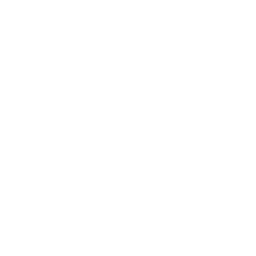

In [6]:
with open('../skia/resources/images/color_wheel.png', 'rb') as f:
    image = skia.Image.MakeFromEncoded(f.read())


with draw_target() as canvas:
    canvas.clear(skia.ColorWHITE)
    matrix = skia.Matrix()
    matrix.setScale(0.75, 0.75)
    matrix.preRotate(30.0)
    paint = skia.Paint()
    paint.setShader(image.makeShader(skia.TileMode.kRepeat, skia.TileMode.kRepeat, matrix))
    canvas.drawPaint(paint)

- Radial Gradient Shader

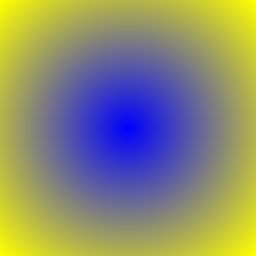

In [7]:
with draw_target() as canvas:
    colors = [skia.ColorBLUE, skia.ColorYELLOW]
    shader = skia.GradientShader.MakeRadial(
        center=(128.0, 128.0),
        radius=180.0,
        colors=colors)
    paint = skia.Paint()
    paint.setShader(shader)
    canvas.drawPaint(paint)

- Two-Point Conical Gradient Shader

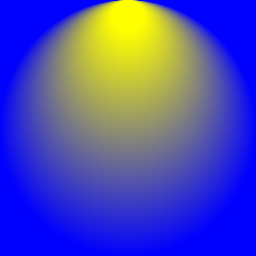

In [8]:
with draw_target() as canvas:
    colors = [skia.ColorBLUE, skia.ColorYELLOW]
    shader = skia.GradientShader.MakeTwoPointConical(
        start=(128.0, 128.0),
        startRadius=128.0,
        end=(128.0, 16.0),
        endRadius=16.0,
        colors=colors)
    paint = skia.Paint()
    paint.setShader(shader)
    canvas.drawPaint(paint)

- Sweep Gradient Shader

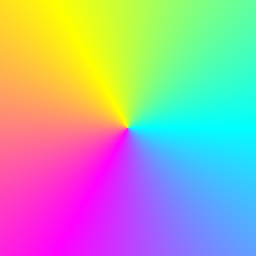

In [9]:
with draw_target() as canvas:
    colors = [skia.ColorCYAN, skia.ColorMAGENTA, skia.ColorYELLOW, skia.ColorCYAN]
    shader = skia.GradientShader.MakeSweep(cx=128.0, cy=128.0, colors=colors)
    paint = skia.Paint()
    paint.setShader(shader)
    canvas.drawPaint(paint)

- Fractal Perlin Noise Shader

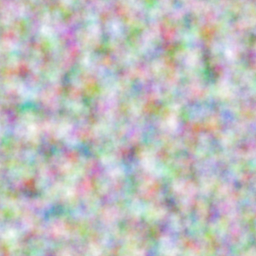

In [10]:
with draw_target() as canvas:
    colors = [skia.ColorWHITE]
    shader = skia.PerlinNoiseShader.MakeFractalNoise(0.05, 0.05, 4, 0.0)
    paint = skia.Paint()
    paint.setShader(shader)
    canvas.drawPaint(paint)

- Turbulence Perlin Noise Shader

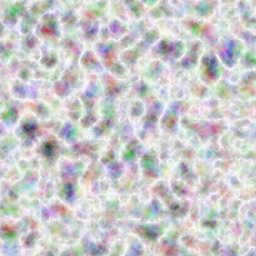

In [11]:
with draw_target() as canvas:
    colors = [skia.ColorWHITE]
    shader = skia.PerlinNoiseShader.MakeTurbulence(0.05, 0.05, 4, 0.0)
    paint = skia.Paint()
    paint.setShader(shader)
    canvas.drawPaint(paint)

- Compose Shader

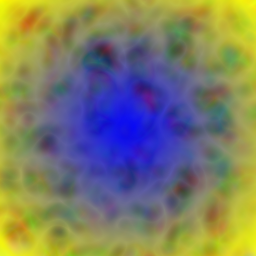

In [12]:
with draw_target() as canvas:
    colors = [skia.ColorBLUE, skia.ColorYELLOW]
    shader = skia.Shaders.Blend(
        skia.BlendMode.kDifference,
        skia.GradientShader.MakeRadial((128.0, 128.0), 180.0, colors),
        skia.PerlinNoiseShader.MakeTurbulence(0.025, 0.025, 2, 0.0))
    paint = skia.Paint()
    paint.setShader(shader)
    canvas.drawPaint(paint)

## MaskFilter

- Blur Mask Filter

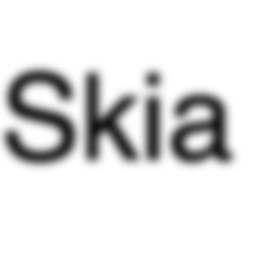

In [13]:
with draw_target() as canvas:
    canvas.drawColor(skia.ColorWHITE)
    paint = skia.Paint()
    paint.setMaskFilter(skia.MaskFilter.MakeBlur(skia.kNormal_BlurStyle, 5.0))
    blob = skia.TextBlob.MakeFromString("Skia", skia.Font(None, 120))
    canvas.drawTextBlob(blob, 0, 160, paint)

## ColorFilter

- Color Matrix Color Filter

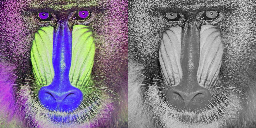

In [14]:
with open('../skia/resources/images/mandrill_512_q075.jpg', 'rb') as f:
    image = skia.Image.MakeFromEncoded(f.read())

def f(canvas, x, y, colorMatrix):
    paint = skia.Paint()
    paint.setColorFilter(skia.ColorFilters.Matrix(colorMatrix))
    canvas.drawImage(image, x, y, paint)
    
with draw_target(256, 128) as canvas:
    canvas.scale(0.25, 0.25)
    colorMatrix = [
        0, 1, 0, 0, 0,
        0, 0, 1, 0, 0,
        1, 0, 0, 0, 0,
        0, 0, 0, 1, 0
    ]
    f(canvas, 0, 0, colorMatrix)
    
    grayscale = [
        0.21, 0.72, 0.07, 0.0, 0.0,
        0.21, 0.72, 0.07, 0.0, 0.0,
        0.21, 0.72, 0.07, 0.0, 0.0,
        0.0,  0.0,  0.0,  1.0, 0.0
    ]
    f(canvas, 512, 0, grayscale)

- Color Table Color Filter

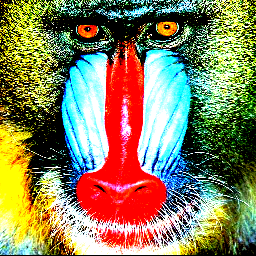

In [15]:
with draw_target() as canvas:
    canvas.scale(0.5, 0.5)
    ct = bytearray(256)
    for i in range(256):
        x = (i - 96) * 255 // 64
        ct[i] = min(255, max(0, x))
    paint = skia.Paint()
    paint.setColorFilter(skia.TableColorFilter.MakeARGB(None, ct, ct, ct))
    canvas.drawImage(image, 0, 0, paint)

## PathEffect

- Path2DPathEffect: Stamp the specified path to fill the shape, using the matrix to define the latice.

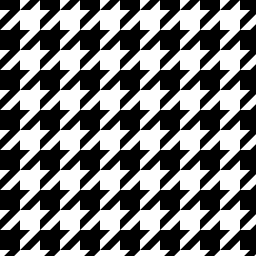

In [16]:
with draw_target() as canvas:
    scale = 10.0
    path = skia.Path()
    pts = [2, 2, 1, 3, 0, 3, 2, 1, 3, 1, 4, 0, 4, 1,
           5, 1, 4, 2, 4, 3, 2, 5, 2, 4, 3, 3, 2, 3]
    path.moveTo(2 * scale, 3 * scale)
    for i in range(0, len(pts), 2):
        path.lineTo(pts[i] * scale, pts[i + 1] * scale)
    path.close()
    
    matrix = skia.Matrix.MakeScale(4 * scale, 4 * scale)
    paint = skia.Paint()
    paint.setPathEffect(skia.Path2DPathEffect.Make(matrix, path))
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    bounds = skia.Rect(-4 * scale, -4 * scale, 256, 256)
    canvas.drawRect(bounds, paint)

- Line2DPathEffect: a special case of Path2DPathEffect where the path is a straight line to be stroked, not a path to be filled.

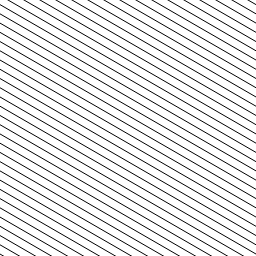

In [17]:
with draw_target() as canvas:
    paint = skia.Paint()
    lattice = skia.Matrix()
    lattice.setScale(8.0, 8.0)
    lattice.preRotate(30.0)
    paint.setPathEffect(skia.Line2DPathEffect.Make(0.0, lattice))
    paint.setAntiAlias(True)
    bounds = skia.Rect.MakeWH(256, 256)
    bounds.outset(8.0, 8.0)
    canvas.clear(skia.ColorWHITE)
    canvas.drawRect(bounds, paint)

- Path1DPathEffect: create dash-like effects by replicating the specified path along the drawn path.

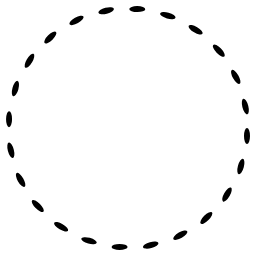

In [18]:
with draw_target() as canvas:
    paint = skia.Paint()
    path = skia.Path()
    path.addOval(skia.Rect(16.0, 6.0))
    paint.setPathEffect(
        skia.Path1DPathEffect.Make(path, 32.0, 0.0, skia.Path1DPathEffect.kRotate_Style))
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    canvas.drawCircle(128.0, 128.0, 122.0, paint)

- CornerPathEffect: a path effect that can turn sharp corners into various treatments (e.g. rounded corners).

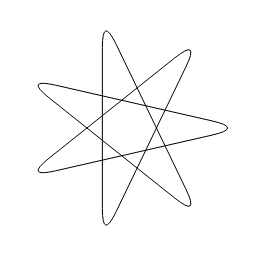

In [19]:
def star():
    from math import cos, sin
    R, C = 115.2, 128.0
    path = skia.Path()
    path.moveTo(C + R, C)
    for i in range(1, 7):
        a = 2.6927937 * i
        path.lineTo(C + R * cos(a), C + R * sin(a))
    path.close()
    return path

with draw_target() as canvas:
    paint = skia.Paint()
    paint.setPathEffect(skia.CornerPathEffect.Make(32.0))
    paint.setStyle(skia.Paint.kStroke_Style)
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    path = star()
    canvas.drawPath(path, paint)

- DashPathEffect: a path effect that implements dashing.

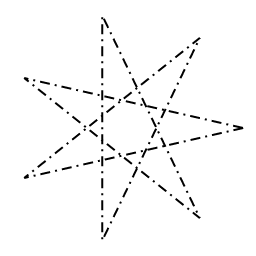

In [20]:
with draw_target() as canvas:
    intervals = [10.0, 5.0, 2.0, 5.0]
    paint = skia.Paint()
    paint.setPathEffect(skia.DashPathEffect.Make(intervals, 0.0))
    paint.setStyle(skia.Paint.kStroke_Style)
    paint.setStrokeWidth(2.0)
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    path = star()
    canvas.drawPath(path, paint)

- DiscretePathEffect: This path effect chops a path into discrete segments, and randomly displaces them.

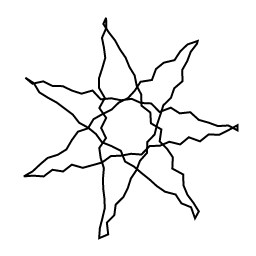

In [21]:
with draw_target() as canvas:
    paint = skia.Paint()
    paint.setPathEffect(skia.DiscretePathEffect.Make(10.0, 4.0))
    paint.setStyle(skia.Paint.kStroke_Style)
    paint.setStrokeWidth(2.0)
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    path = star()
    canvas.drawPath(path, paint)

- ComposePathEffect: a pathEffect whose effect is to apply first the inner pathEffect and the the outer pathEffect (i.e. outer(inner(path))).

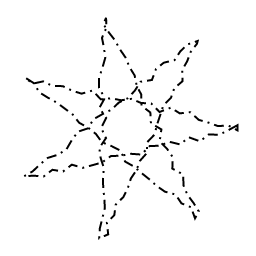

In [22]:
with draw_target() as canvas:
    intervals = [10.0, 5.0, 2.0, 5.0]
    paint = skia.Paint()
    paint.setPathEffect(
        skia.PathEffect.MakeCompose(
            skia.DashPathEffect.Make(intervals, 0.0),
            skia.DiscretePathEffect.Make(10.0, 4.0)))
    paint.setStyle(skia.Paint.kStroke_Style)
    paint.setStrokeWidth(2.0)
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    path = star()
    canvas.drawPath(path, paint)

- SumPathEffect: a pathEffect whose effect is to apply two effects, in sequence (i.e. first(path) + second(path)).

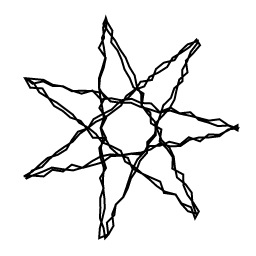

In [23]:
with draw_target() as canvas:
    intervals = [10.0, 5.0, 2.0, 5.0]
    paint = skia.Paint()
    paint.setPathEffect(
        skia.PathEffect.MakeSum(
            skia.DiscretePathEffect.Make(10.0, 4.0),
            skia.DiscretePathEffect.Make(10.0, 4.0, 1245)))
    paint.setStyle(skia.Paint.kStroke_Style)
    paint.setStrokeWidth(2.0)
    paint.setAntiAlias(True)
    canvas.clear(skia.ColorWHITE)
    path = star()
    canvas.drawPath(path, paint)